In [7]:
import numpy as np
from PIL import Image
from IPython.display import display
import cv2
import keras.backend as K
from hashlib import sha256
from keras.preprocessing.image import load_img, array_to_img, img_to_array
from keras.utils import get_file
import matplotlib.pyplot as plt
from keras.models import load_model

In [4]:
model = load_model('cifar10_ResNet20v1_model.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [10]:
labels = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]


def do_gradcam(model, url: str, layer_name: str, display_shape: tuple) -> tuple:
    # download and load image
    
    input_shape = model.layers[0].input_shape[1:]
    
    fname = f'image_{sha256(url.encode()).hexdigest()}.png'
    fpath = get_file(fname, url)
        
    im = load_img(fpath, target_size=input_shape)
    x = img_to_array(im)
    x = np.expand_dims(x, axis=0)    
    x = x.astype('float32') / 255
    
    # 1. We get the predictions for the image
    # 2. We take the topmost class index
    # 3. Take output from the given layer

    preds = model.predict(x)
    class_idx = np.argmax(preds)
    class_label = labels[class_idx]

    class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer(layer_name)
    
    # 1. Compute the gradient of the class output value with respect to the feature map
    # 2. Pool the gradients over all the axies leaving out the channel dimension
    # 3. Weigh the output feature map with the computed gradient values
    
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

    pooled_grads_value, conv_layer_output_value = iterate([x])
    
    for i in range(pooled_grads.shape[0]):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
    # 1. Average the weighted feature map along the channel dimension resulting in a heat map of size 14x14
    # 2. Normalize the heat map to make the values between 0 and 1

    heatmap = np.mean(conv_layer_output_value, axis = -1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
 
    # resize and superimpose heatmap
    
    heatmap = cv2.resize(heatmap, display_shape)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)    
    
    heatmap_img = array_to_img(heatmap)
    display_img = Image.open(fpath).resize(display_shape)        
    display_x = np.uint8(img_to_array(display_img))
        
    superimposed = cv2.addWeighted(display_x, 0.5, heatmap, 0.5, 0)
    superimposed_img = array_to_img(superimposed)

    return class_label, display_img, heatmap_img, superimposed_img

predicticted class: airplane


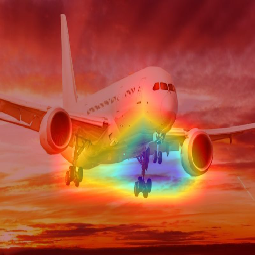

predicticted class: automobile


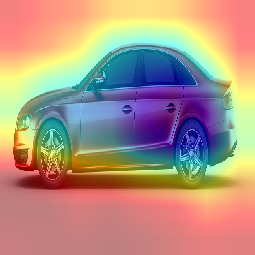

predicticted class: bird


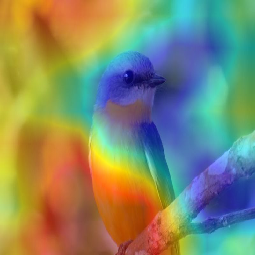

predicticted class: cat


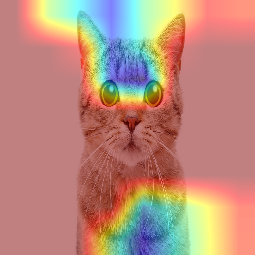

predicticted class: frog


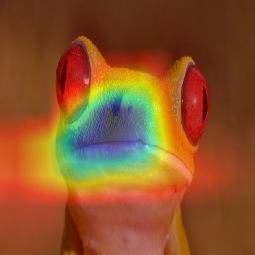

predicticted class: deer


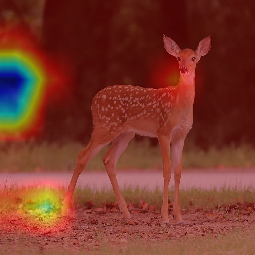

predicticted class: ship


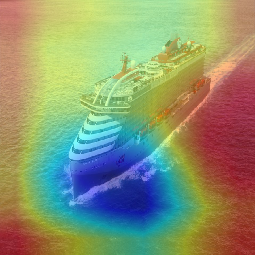

predicticted class: bird


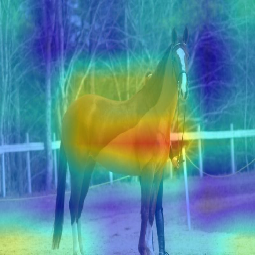

predicticted class: dog


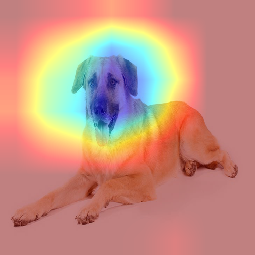

predicticted class: truck


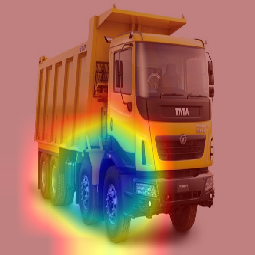

In [11]:
test_urls = [
    'https://scx1.b-cdn.net/csz/news/800/2019/toomanyairpl.jpg',
    'https://www.teckinfo.com/images/automobile_img.jpg',
    'https://scx1.b-cdn.net/csz/news/800/2019/mostnativebi.jpg',
    'https://timesofindia.indiatimes.com/thumb/msid-67586673,width-800,height-600,resizemode-4/67586673.jpg',
    'https://ichef.bbci.co.uk/news/624/cpsprodpb/3DA1/production/_96777751_c0220207-red-eyed_treefrog-spl.jpg',
    'https://media.arkansasonline.com/img/photos/2019/06/17/resized_250499-1b-deer-0618_85-26607_t800.JPG?90232451fbcadccc64a17de7521d859a8f88077d',
    'https://specials-images.forbesimg.com/imageserve/5dd2ed8de0af7b0006b19dfc/960x0.jpg?fit=scale',
    'https://scx1.b-cdn.net/csz/news/800/2019/isyourhorsen.jpg',
    'https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/12234558/Chinook-On-White-03.jpg',
    'https://www.tatamotors.com/wp-content/uploads/2018/01/19065024/prima.jpg',
]

display_shape = (255, 255)

for url in test_urls:    
    class_label, display_img, heatmap_img, superimposed_img = do_gradcam(model, url, 'conv2d_63', display_shape)
    print('predicticted class:', class_label)
    display(superimposed_img)